In [3]:
import os
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    classification_report,
)

# Data


In [4]:
path = Path(
    "/kaggle/input/covid-wwo-pneumonia-chest-xray/Data"
    if os.path.exists("/kaggle/input/covid-wwo-pneumonia-chest-xray/Data")
    else "Data"
)

covid_without_PNEUMONIA_train_path = path / "train" / "covid_without_PNEUMONIA"
covid_with_PNEUMONIA_train_path = path / "train" / "covid_with_PNEUMONIA"

covid_without_PNEUMONIA_test_path = path / "test" / "covid_without_PNEUMONIA"
covid_with_PNEUMONIA_test_path = path / "test" / "covid_with_PNEUMONIA"

In [5]:
covid_without_PNEUMONIA_path = [
    covid_without_PNEUMONIA_train_path,
    covid_without_PNEUMONIA_test_path,
]

covid_with_PNEUMONIA_path = [
    covid_with_PNEUMONIA_train_path,
    covid_with_PNEUMONIA_test_path,
]

In [6]:
np.random.seed(42)
random.seed(42)

In [7]:
label2category = {"covid_without_PNEUMONIA": 0, "covid_with_PNEUMONIA": 1}
category2label = {0: "covid_without_PNEUMONIA", 1: "covid_with_PNEUMONIA"}

In [8]:
data = []

for path in covid_without_PNEUMONIA_path:
    for img in path.glob("*.jpeg"):
        data.append({"img_path": str(img), "label": "covid_without_PNEUMONIA"})

for path in covid_with_PNEUMONIA_path:
    for img in path.glob("*.jpeg"):
        data.append({"img_path": str(img), "label": "covid_with_PNEUMONIA"})

In [9]:
def counter_label(data=None, key=None, index=None):
    label = []
    for value in data:
        label.append(value[key])
    return Counter(label)

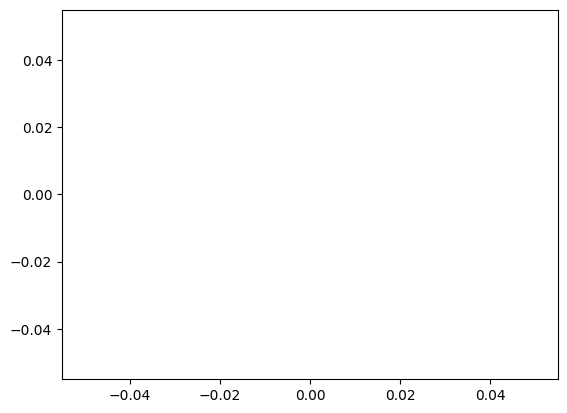

In [10]:
img_l_counter = counter_label(data, "label")
keys = img_l_counter.keys()
values = img_l_counter.values()
plt.bar(keys, values)
plt.show()

In [11]:
plt.figure(figsize=(20, 7))

for i, data_ in enumerate(data[:10]):
    path, label = data_["img_path"], data_["label"]
    plt.subplot(2, 5, i + 1)
    img = cv2.imread(path)
    plt.imshow(img)
    plt.xlabel(label)

plt.show()

<Figure size 2000x700 with 0 Axes>

In [12]:
def rotate(image, angle=90, scale=1.0):
    # Get the dimensions of the image
    (h, w) = image.shape[:2]
    # Compute the center of the image
    center = (w / 2, h / 2)
    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

In [13]:
def flip(image, flipCode=0):
    # Flip the image horizontally, vertically, or both
    # flipCode = 0: flip vertically
    # flipCode > 0: flip horizontally
    # flipCode < 0: flip vertically and horizontally
    flipped = cv2.flip(image, flipCode)
    return flipped

In [14]:
%%time

images_array = []
images_label = []

IMG_SIZE = (100, 100)

for data_ in data:
    category = label2category[data_["label"]]
    img = cv2.imread(data_["img_path"])
    if category == 0:
        random_angle = random.choice([90, 180, 270])
        random_flip = random.choice([-1, 0, 1])
        for i in range(2):
            img = rotate(img, angle=random_angle)
            img = flip(img, flipCode=random_flip)
            img = cv2.resize(img, IMG_SIZE)
            images_array.append(img)
            images_label.append(data_["label"])
    else:
        img = cv2.resize(img, IMG_SIZE)
        images_array.append(img)
        images_label.append(data_["label"])

CPU times: total: 0 ns
Wall time: 0 ns


In [15]:
np.unique(images_label)

array([], dtype=float64)

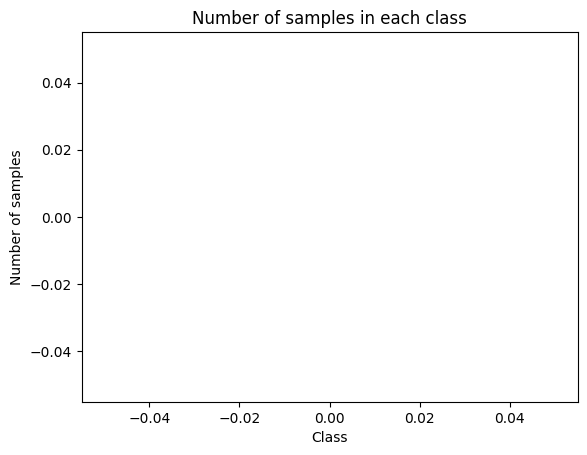

In [16]:
# plot number of samples in each class

# Assuming 'data' is your numpy array with class labels
classes, counts = np.unique(images_label, return_counts=True)
plt.bar(classes, counts)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Number of samples in each class")
plt.show()

In [17]:
images_array = np.array(images_array)
images_label = np.array(images_label)

print("shape of images array: {}".format(images_array.shape))
print("shape of images label: {}".format(images_label.shape))

shape of images array: (0,)
shape of images label: (0,)


In [18]:
plt.figure(figsize=(20, 7))

for i, data_ in enumerate(images_array[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(data_)
    plt.xlabel(images_label[i])

plt.show()

<Figure size 2000x700 with 0 Axes>

In [19]:
images_label = np.where(images_label == "covid_without_PNEUMONIA", 0, 1)

# Feature Extraction


In [20]:
def calculate_centroid(block):
    """Calculate the centroid of a 3D matrix"""
    rows, cols, dep = block.shape
    x_centroid = 0.0
    y_centroid = 0.0
    z_centroid = 0.0
    for i in range(rows):
        for j in range(cols):
            for k in range(dep):
                x_centroid += i * block[i, j, k]
                y_centroid += j * block[i, j, k]
                z_centroid += k * block[i, j, k]
    total = np.sum(block)
    x_centroid = x_centroid / total
    y_centroid = y_centroid / total
    z_centroid = z_centroid / total
    return x_centroid, y_centroid, z_centroid

In [21]:
def extract_features_with_centroid(image, block_size=50):
    features = np.zeros((100 // block_size, 100 // block_size, 3))
    for i in range(0, 100, block_size):
        for j in range(0, 100, block_size):
            block = image[i : i + block_size, j : j + block_size]
            x_centroid, y_centroid, z_centroid = calculate_centroid(block)
            features[int(i / block_size), int(j / block_size), 0] = x_centroid
            features[int(i / block_size), int(j / block_size), 1] = y_centroid
            features[int(i / block_size), int(j / block_size), 2] = z_centroid
    return features

In [22]:
x_train, x_test, y_train, y_test = train_test_split(
    images_array, images_label, test_size=0.3
)

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
print("train input shape: {}".format(x_train.shape))
print("train output shape: {}".format(y_train.shape))
print("test input shape: {}".format(x_test.shape))
print("test output shape: {}".format(y_test.shape))

train input shape: (402, 100, 100, 3)
train output shape: (402,)
test input shape: (173, 100, 100, 3)
test output shape: (173,)


In [ ]:
%%time

train_features_with_centroid = np.nan_to_num(
    np.array([extract_features_with_centroid(image) for image in x_train])
)

test_features_with_centroid = np.nan_to_num(
    np.array([extract_features_with_centroid(image) for image in x_test])
)

CPU times: user 3min 20s, sys: 30.5 ms, total: 3min 20s
Wall time: 3min 21s


In [ ]:
train_features_with_centroid.shape, test_features_with_centroid.shape

((402, 2, 2, 3), (173, 2, 2, 3))

In [ ]:
train_features_with_centroid = train_features_with_centroid.reshape(
    train_features_with_centroid.shape[0], -1
)

test_features_with_centroid = test_features_with_centroid.reshape(
    test_features_with_centroid.shape[0], -1
)

In [ ]:
train_features_with_centroid.shape

(402, 12)

# Model


In [ ]:
class LogisticRegression:
    def __init__(
        self,
        lr=0.01,
        num_iter=1000,
        verbose=False,
    ):
        self.lr = lr
        self.num_iter = num_iter
        self.verbose = verbose
        self.weights = None
        self.bias = None
        self.x = None
        self.y = None
        self.classes_ = None
        self.m = None
        self.n = None
        self.losses = []
        self.accuracies = []

    def gradient_descent(self):
        y_hat = self.predict(self.x)
        dw = (1 / self.m) * np.dot(self.x.T, (y_hat - self.y))
        db = (1 / self.m) * np.sum(y_hat - self.y)
        self.weights -= self.lr * dw
        self.bias -= self.lr * db

    def predict(self, x):
        z = np.dot(x, self.weights) + self.bias
        predication = 1.0 / (1.0 + np.exp(-z))
        return predication

    def plot(self):
        plt.plot(self.losses)
        plt.plot(self.accuracies)
        plt.xlabel("Number of iterations")
        plt.ylabel("Loss")
        plt.legend(["Loss", "Accuracy"])
        plt.show()

    def loss(self):
        y_hat = self.predict(self.x)
        self.losses.append(
            -np.mean(
                self.y * np.log(y_hat + sys.float_info.min)
                + (1 - self.y) * np.log(1 - y_hat + sys.float_info.min)
            )
        )
        return self.losses[-1]

    def accuracy(self):
        y_hat = self.predict(self.x)
        acc = np.mean(y_hat.round() == self.y)
        self.accuracies.append(acc)

    def F1_score(self):
        y_hat = self.predict(self.x)
        return f1_score(self.y, y_hat.round())

    def precision(self):
        y_hat = self.predict(self.x)
        return precision_score(self.y, y_hat.round())

    def recall(self):
        y_hat = self.predict(self.x)
        return recall_score(self.y, y_hat.round())

    def fit(self, x, y):
        self.x = x
        self.y = y
        best_loss = sys.float_info.max
        patience = 5
        self.m, self.n = x.shape
        self.weights = np.random.rand(self.n)
        self.bias = np.random.rand()
        for _ in range(self.num_iter):
            self.gradient_descent()
            self.loss()
            self.accuracy()

            if self.losses[-1] < best_loss:
                best_loss = self.losses[-1]
                patience = 5
            else:
                patience -= 1
                if patience == 0:
                    break

        if self.verbose:
            print(f"\nFinal Loss: {self.losses[-1]}")
            print(f"Final Accuracy: {self.accuracies[-1]}")

    def eval(self, x, y):
        self.x = x
        self.y = y
        self.accuracy()
        if self.verbose:
            print(f"Accuracy: {self.accuracies[-1]}")
            print(f"F1 Score: {self.F1_score()}")
            print(f"Precision: {self.precision()}")
            print(f"Recall: {self.recall()}")

In [ ]:
model = LogisticRegression(verbose=True)

In [ ]:
np.unique(y_train), np.unique(y_test)

(array([0, 1]), array([0, 1]))

In [ ]:
train_features_with_centroid = (
    train_features_with_centroid - train_features_with_centroid.mean()
) / train_features_with_centroid.std()


test_features_with_centroid = (
    test_features_with_centroid - test_features_with_centroid.mean()
) / test_features_with_centroid.std()

In [ ]:
model.fit(train_features_with_centroid, y_train)


Final Loss: 0.6108794662750758
Final Accuracy: 0.7910447761194029


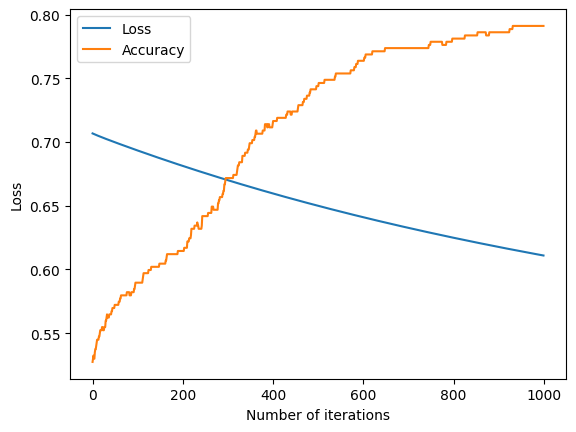

In [ ]:
model.plot()

In [ ]:
model.eval(train_features_with_centroid, y_train)

Accuracy: 0.7910447761194029
F1 Score: 0.8326693227091634
Precision: 0.7206896551724138
Recall: 0.9858490566037735


In [ ]:
model.eval(test_features_with_centroid, y_test)

Accuracy: 0.7687861271676301
F1 Score: 0.7872340425531914
Precision: 0.6666666666666666
Recall: 0.961038961038961


In [ ]:
print(classification_report(y_test, model.predict(test_features_with_centroid).round()))

              precision    recall  f1-score   support

           0       0.95      0.61      0.75        96
           1       0.67      0.96      0.79        77

    accuracy                           0.77       173
   macro avg       0.81      0.79      0.77       173
weighted avg       0.82      0.77      0.76       173



In [ ]:
x_train.shape[1]

100

In [ ]:
y_train.shape

(402,)

# Particle Swarm Optimization


In [ ]:
tries = []

In [ ]:
# class Particle:
#     def __init__(self, lr):
#         # self.x = x
#         self.lr = lr
#         # self.best_x = x
#         self.best_lr = lr
#         self.best_loss = sys.float_info.max
#         self.loss = sys.float_info.max
#         self.velocity = np.random.rand(1)

#     def update(self, loss):
#         self.loss = loss
#         if loss < self.best_loss:
#             self.best_loss = loss
#             self.best_lr = self.lr

#     def move(self):
#         # self.x += self.velocity[0]
#         self.lr += self.velocity[0]

#     def __repr__(self):
#         return f"Particle(lr={self.lr}, loss={self.loss})"


# class Swarm:
#     def __init__(self, objective_function, bounds, maxiter=100, debug=False):
#         self.particles = []
#         self.best_loss = sys.float_info.max
#         self.best_value = None
#         self.objective_function = objective_function
#         self.bounds = bounds
#         self.maxiter = maxiter
#         self.debug = debug
#         for _ in range(100):
#             # x = np.random.randint(bounds[0][0], bounds[0][1])
#             lr = np.random.uniform(bounds[0][0], bounds[0][1])
#             self.particles.append(Particle(lr))

#     def run(self):
#         for _ in range(self.maxiter):
#             for particle in self.particles:
#                 loss = self.objective_function(particle.lr)
#                 particle.update(loss)
#                 if loss < self.best_loss:
#                     self.best_loss = loss
#                     self.best_value = particle.lr
#             if self.debug:
#                 print(f"Best Loss: {self.best_loss}, Best Value: {self.best_value}")


# def objective_function(LR):
#     tries.append(LR)
#     print(f"\tTrying Subset: {LR[0]}, LR: {LR[1]}")
#     model = LogisticRegression(lr=LR)
#     model.fit(train_features_with_centroid, y_train)
#     model.eval(test_features_with_centroid, y_test)
#     return -model.F1_score()

In [ ]:
# swarm = Swarm(objective_function, [[0.01, 0.99]], maxiter=100, debug=True)

In [ ]:
# swarm.run()

In [ ]:
class Particle:
    def __init__(self, bounds):
        self.position = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
        self.velocity = np.array(
            [np.random.uniform(-abs(b[1] - b[0]), abs(b[1] - b[0])) for b in bounds]
        )
        self.best_position = self.position.copy()
        self.best_fitness = float("inf")
        self.fitness = float("inf")


def update_velocity(particle, global_best_position, w=0.5, c1=1.0, c2=2.0):
    inertia = w * particle.velocity
    cognitive = c1 * np.random.random() * (particle.best_position - particle.position)
    social = c2 * np.random.random() * (global_best_position - particle.position)
    particle.velocity = inertia + cognitive + social


def update_position(particle, bounds):
    particle.position += particle.velocity
    # Ensure the particle's position is within the bounds
    for i in range(len(bounds)):
        if particle.position[i] < bounds[i][0]:
            particle.position[i] = bounds[i][0]
        elif particle.position[i] > bounds[i][1]:
            particle.position[i] = bounds[i][1]


def objective_function(subset):
    tries.append(subset)
    print(f"\tTrying Subset: {round(subset[0])}, LR: {subset[1]}")
    X_train_subset = train_features_with_centroid[:, : round(subset[0])]
    X_test_subset = test_features_with_centroid[:, : round(subset[0])]
    model = LogisticRegression(lr=subset[1])
    model.fit(X_train_subset, y_train)
    model.eval(X_test_subset, y_test)
    return -model.F1_score()


def pso(objective_function, bounds, num_particles, max_iter):
    swarm = [Particle(bounds) for _ in range(num_particles)]
    global_best_position = np.zeros(len(bounds))
    global_best_fitness = float("inf")
    for iteration in range(max_iter):
        for particle in swarm:
            particle.fitness = objective_function(particle.position)
            if particle.fitness < particle.best_fitness:
                particle.best_fitness = particle.fitness
                particle.best_position = particle.position.copy()
            if particle.fitness < global_best_fitness:
                global_best_fitness = particle.fitness
                global_best_position = particle.position.copy()
        for particle in swarm:
            update_velocity(particle, global_best_position)
            update_position(particle, bounds)
        print(
            f"Iteration {iteration+1}/{max_iter}, Global Best Fitness: {-global_best_fitness}, Global Best Position: {global_best_position}"
        )
    return global_best_position, -global_best_fitness


In [ ]:
best_position, best_fitness = pso(
    objective_function, bounds=[(2, 12), (0.01, 0.99)], num_particles=10, max_iter=100
)

Iteration 1/100, Global Best Fitness: 0.8571428571428571, Global Best Position: [8.84571548 0.09611075]
Iteration 2/100, Global Best Fitness: 0.8571428571428571, Global Best Position: [8.84571548 0.09611075]
Iteration 3/100, Global Best Fitness: 0.8571428571428571, Global Best Position: [8.84571548 0.09611075]
Iteration 4/100, Global Best Fitness: 0.8571428571428571, Global Best Position: [8.84571548 0.09611075]
Iteration 5/100, Global Best Fitness: 0.8571428571428571, Global Best Position: [8.84571548 0.09611075]
Iteration 6/100, Global Best Fitness: 0.8571428571428571, Global Best Position: [8.84571548 0.09611075]
Iteration 7/100, Global Best Fitness: 0.8571428571428571, Global Best Position: [8.84571548 0.09611075]
Iteration 8/100, Global Best Fitness: 0.8571428571428571, Global Best Position: [8.84571548 0.09611075]
Iteration 9/100, Global Best Fitness: 0.8571428571428571, Global Best Position: [8.84571548 0.09611075]
Iteration 10/100, Global Best Fitness: 0.8571428571428571, Globa

In [ ]:
print(f"Best Position: {best_position}, Best Fitness: {best_fitness}")

Best Position: [8.84572292 0.09611088], Best Fitness: 0.8620689655172413


In [ ]:
subsets = np.unique(tries[0])
lrs = np.unique(tries[1])

In [ ]:
subsets, lrs

# After Particle Swarm Optimization


In [ ]:
model = LogisticRegression(verbose=True)

In [ ]:
model.fit(train_features_with_centroid[:, : round(best_position[0])], y_train)

In [ ]:
model.plot()

In [ ]:
model.eval(train_features_with_centroid[:, : round(best_position[0])], y_train)

In [ ]:
model.eval(test_features_with_centroid[:, : round(best_position[0])], y_test)

In [ ]:
print(
    classification_report(
        y_test,
        model.predict(
            test_features_with_centroid[:, : round(best_position[0])]
        ).round(),
    )
)

# Feature Reduction


In [ ]:
class LDA:
    def __init__(self):
        self.w = None

    def fit(self, X, y):
        m0 = np.mean(X[y == 0], axis=0)
        m1 = np.mean(X[y == 1], axis=0)
        S0 = np.dot((X[y == 0] - m0).T, (X[y == 0] - m0))
        S1 = np.dot((X[y == 1] - m1).T, (X[y == 1] - m1))
        Sw = S0 + S1
        self.w = np.dot(np.linalg.inv(Sw), (m1 - m0))

    def transform(self, X):
        result = np.dot(X, self.w)
        return (result - result.mean()) / result.std()

In [ ]:
lda = LDA()

In [ ]:
lda.fit(train_features_with_centroid[:, : round(best_position[0])], y_train)

In [ ]:
train_features_with_centroid = lda.transform(
    train_features_with_centroid[:, : round(best_position[0])]
)
test_features_with_centroid = lda.transform(
    test_features_with_centroid[:, : round(best_position[0])]
)


In [ ]:
train_features_with_centroid = train_features_with_centroid.reshape(-1, 1)
test_features_with_centroid = test_features_with_centroid.reshape(-1, 1)

In [ ]:
train_features_with_centroid.shape, test_features_with_centroid.shape

# After Feature Reduction

In [ ]:
model = LogisticRegression(verbose=True)

In [ ]:
model.fit(train_features_with_centroid, y_train)

In [ ]:
model.plot()

In [ ]:
model.eval(train_features_with_centroid, y_train)

In [ ]:
model.eval(test_features_with_centroid, y_test)

In [ ]:
print(classification_report(y_test, model.predict(test_features_with_centroid).round())